In [1]:
import numpy as np
import os
from imutils import paths
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [2]:
Labels_Data=[]
Images_Data=[]

# Load_Face_Mask_Dataset

In [4]:
Directory='C:\\Users\\Dell\\Downloads\\Face-Mask-Detection-master\\Face-Mask-Detection-master\\dataset'
Categories=['with_mask','without_mask']# -> these are the names of folder in whcih we have relevent images 

In [5]:
for classes in Categories:
    dir_path=os.path.join(Directory, classes) #to join Directory and Categories 
    for images in os.listdir(dir_path):#list all path to images in a random order
        images=os.path.join(dir_path , images)#again joining dir_path and images to reach a specific image in folders with_mask and without_mask
        images_loaded=load_img(images, target_size=(224,224))# loading images with size=(224,224)
        images_to_array=img_to_array(images_loaded) #converting images to array form
        images=preprocess_input(images_to_array) #needed to preprocess when we use MobileNet
        
        Labels_Data.append(classes)
        Images_Data.append(images)
        

C:\Vs\anaconda3\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# Labels_Encoding

In [6]:
LB=LabelBinarizer() 

In [7]:
Labels_to_Binary=LB.fit_transform(Labels_Data)
#sklearn class that accepts Categorical data as input & returns numpy array (0,1 form)

In [8]:
Labels_dataset=to_categorical(Labels_to_Binary)#Converts vector Integers into Binary class matrix  
#-> used with Binary_crossentropy

# Converting Images/Labels in Array

In [10]:
Images_Dataset=np.array(Images_Data,dtype='float32')
Labels_Dataset=np.array(Labels_dataset)

# Train_test Splitting

In [11]:
X_train,X_test,y_train,y_test=train_test_split(Images_Dataset, Labels_Dataset, test_size=0.2, random_state=51)

# Argumentation of Data

In [12]:
Argumented_data=ImageDataGenerator(rotation_range=20, shear_range=0.15, zoom_range=0.15, horizontal_flip=True, 
                                  width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest')

# Model Building

In [15]:
Bottom_Layers=MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
#using weights saved in imagenet , not including top_Layers , and giving input_tensor shape of  image 224, 224 width & 
#hieght respectively and 3 is color channels RedGreenBlue(RGB)


In [18]:
#Building Top_layers
Top_Layers=Bottom_Layers.output
Top_Layers=AveragePooling2D(pool_size=(7,7))(Top_Layers)
Top_Layers=Flatten(name='Flatten_layer')(Top_Layers)
Top_Layers=Dense(128, activation='relu')(Top_Layers)# 128 neurons with activation function 'relu' -> used with images always
Top_Layers=Dropout(0.5)(Top_Layers)# Droping 50% neurons to aviod overfitting
Top_Layers=Dense(2, activation='softmax')(Top_Layers) # 2 means classes with_mask, without_mask



In [19]:
model=Model(inputs=Bottom_Layers.input, outputs=Top_Layers)

In [21]:
for layers in Bottom_Layers.layers:
    layers.trainable=False
#Loop on Bottom_layer to freeze them not getting updated during 1st training process

# Model Compilation

In [25]:
epochs=5
batch_size=64
lr=1e-4
optimizer=Adam(lr=lr, decay=lr/epochs)

In [26]:
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model Training 

In [28]:
Histroy=model.fit(Argumented_data.flow(X_train, y_train, batch_size=64), steps_per_epoch=len(X_train)//batch_size,
                 validation_data=(X_test, y_test),validation_steps=len(X_test)//batch_size, epochs=epochs)

Epoch 1/5
47/47 [==============================] - 985s 21s/step - loss: 0.5854 - accuracy: 0.7372 - val_loss: 0.3104 - val_accuracy: 0.9700
Epoch 2/5
47/47 [==============================] - 961s 21s/step - loss: 0.2603 - accuracy: 0.9360 - val_loss: 0.1580 - val_accuracy: 0.9857
Epoch 3/5
47/47 [==============================] - 787s 17s/step - loss: 0.1559 - accuracy: 0.9647 - val_loss: 0.1017 - val_accuracy: 0.9857
Epoch 4/5
47/47 [==============================] - 728s 15s/step - loss: 0.1186 - accuracy: 0.9720 - val_loss: 0.0764 - val_accuracy: 0.9883
Epoch 5/5
47/47 [==============================] - 769s 16s/step - loss: 0.0994 - accuracy: 0.9737 - val_loss: 0.0620 - val_accuracy: 0.9909


# Classification Report

In [29]:
prediction=model.predict(X_test, batch_size=batch_size)

12/12 [==============================] - 77s 3s/step


In [30]:
prediction_prob_max=np.argmax(prediction, axis=1)#to get max probability on X_test predictions

In [31]:
print(classification_report(y_test.argmax(axis=1), prediction_prob_max, target_names=LB.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       375
without_mask       0.99      0.99      0.99       392

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



# Saving Model

In [32]:
model.save('Face_Mask_Detection.model', save_format='h5')

# Plotting Results

In [33]:
plt.style.use('ggplot')
plt.figure(figsize=(6,6))

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

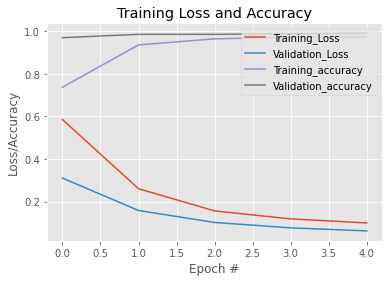

In [40]:
#0 to 5 as 5 epochs we are performing
plt.plot(np.arange(0,5),Histroy.history['loss'],label='Training_Loss')
plt.plot(np.arange(0,5), Histroy.history['val_loss'], label='Validation_Loss')
plt.plot(np.arange(0,5), Histroy.history['accuracy'], label='Training_accuracy')
plt.plot(np.arange(0,5), Histroy.history['val_accuracy'], label='Validation_accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

In [41]:
plt.savefig('Graphical_reults.jpeg')

<Figure size 432x288 with 0 Axes>